### 準備

In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO, SAC
from stable_baselines3 import DDPG

from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

import os
import sys
sys.path.append(os.path.pardir)

from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *
from cpm_torch.Training.CPM_SAC_Policy import *
from cpm_torch.CPMDiffusionEnv import CPMDiffusionEnv
from cpm_torch.Training.utils.Callbacks import SaveOnlyRecentCallback, HyperParametersWriteCallback

import cProfile
import pstats

error: XDG_RUNTIME_DIR not set in the environment.


In [2]:
from datetime import datetime

def create_timestamped_results_dir(base_dir="results/PPOs"):
    """
    Creates a timestamped directory within the base results directory.
    
    Args:
        base_dir (str): Base directory where the timestamped folder will be created
        
    Returns:
        str: Path to the created directory
    """
    # Create the base directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a timestamp string
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Create the full path
    result_dir = os.path.join(base_dir, timestamp)
    
    # Create the directory
    os.makedirs(result_dir)
    
    print(f"Created results directory: {result_dir}")
    return result_dir


is_continue = False  # Set to True if you want to continue training from a previous model

if is_continue:
    result_dir = "results/PPOs/20250513-041642"  # Example directory for demonstration
    model_dir = os.path.join(result_dir, "recent_model")
else:
    result_dir = create_timestamped_results_dir()

Created results directory: results/PPOs/20250604-024727


### ハイパーパラメータ

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    size=(64, 64),  # 画像サイズ
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=75.0,  # 目標細胞面積 A_0
    L_0=40.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
    diffusion_channels=[],#, 3, 4, 5, 6, 7, 8],  # 拡散チャネル数
    diffusion_D = [],#, 0.05, 0.1, 0.2, 0.05, 0.1, 0.2],
    diffusion_percent = []#, 1, 1, 1, 0, 0, 0] # 拡散割合
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (64, 64), 'dim': 2, 'height': 64, 'width': 64, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 75.0, 'L_0': 40.0, 'T': 1.0, 'diffusion_channels': [], 'other_channels': 0, 'diffusion_D': [], 'diffusion_percent': []}


### 環境

torch.Size([64, 64, 2])


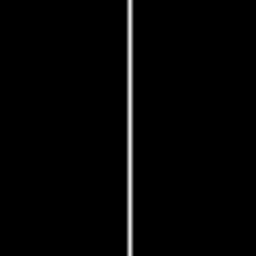

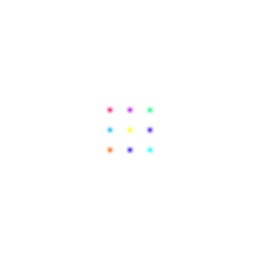

In [4]:
env = CPMEnv(config, device=device)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

In [5]:
eval_freq = 1000
best_model_save_path = os.path.join(result_dir, "best_model")
n_eval_episodes = 50

eval_callback = EvalCallback(
    env,    # 評価環境
    log_path='path/to/log',
    eval_freq=eval_freq,
    deterministic=True,
    render=True,
    best_model_save_path=best_model_save_path,
    n_eval_episodes=n_eval_episodes
)

recent_callback = SaveOnlyRecentCallback(
    save_freq=5000,
    save_path=result_dir,
    name_prefix='recent_model',
    save_replay_buffer=False,
    save_vecnormalize=False
)
hyper_params_callback = HyperParametersWriteCallback()

In [6]:


model = SAC(CPM_SAC_Policy, env, tensorboard_log=os.path.join(result_dir), verbose=1 , gradient_steps=10)#batch_size=64)
# パラメータ数を表示
print(f"Number of parameters: {sum(p.numel() for p in model.policy.parameters())}")
for name, param in model.policy.named_parameters():
    print(f"{name}: {param.size()}")
print(model.policy)




Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Number of parameters: 38745520
actor.latent_pi.fc1.weight: torch.Size([256, 18])
actor.latent_pi.fc1.bias: torch.Size([256])
actor.latent_pi.fc2.weight: torch.Size([256, 256])
actor.latent_pi.fc2.bias: torch.Size([256])
actor.latent_pi.fc3.weight: torch.Size([128, 256])
actor.latent_pi.fc3.bias: torch.Size([128])
actor.latent_pi.fc_mean.weight: torch.Size([4, 128])
actor.latent_pi.fc_mean.bias: torch.Size([4])
actor.latent_pi.fc_log_std.weight: torch.Size([4, 128])
actor.latent_pi.fc_log_std.bias: torch.Size([4])
actor.mu.weight: torch.Size([1936, 256])
actor.mu.bias: torch.Size([1936])
actor.log_std.weight: torch.Size([1936, 256])
actor.log_std.bias: torch.Size([1936])
critic.qf0.u_net1.downs.0.double_conv.0.weight: torch.Size([64, 2, 3, 3])
critic.qf0.u_net1.downs.0.double_conv.0.bias: torch.Size([64])
critic.qf0.u_net1.downs.0.double_conv.1.weight: torch.Size([64])
critic.qf0.u_net1.downs.

In [7]:
# pr = cProfile.Profile()
# pr.enable()

model.learn(
    total_timesteps=1000000,
    progress_bar=True,
    callback=[recent_callback, hyper_params_callback],
)  # 学習を実行

# pr.disable()

# s = io.StringIO()
# # sortby は 'cumulative' (累積時間), 'tottime' (内部時間), 'calls' (呼び出し回数) など
# ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
# ps.print_stats() # 結果を表示
# pr.dump_stats('model_learn.prof')

Logging to results/PPOs/20250604-024727/SAC_1


/root/.pyenv/versions/3.9.17/lib/python3.9/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyboardInterrupt: 

In [ ]:

step = 200      # シミュレーションのエポック数
mcs_per_step = 20 # 1エポックあたりのCPMステップ数
diffusion_steps = 5 # 1 CPMステップあたりの拡散ステップ数

model = SAC.load(os.path.join("results/PPOs/20250603-010127", "recent_model_32000_steps"), env=env)  # 学習済みモデルの読み込み

writer = LoopWriter(filename='../results/cpm_torch_jp.mp4', fps=10) # ループ動画ライター
writers = []
for i in range(config.other_channels):
    writers.append(LoopWriter(filename=f'../results/cpm_torch_jp_{i}.mp4', fps=10))  # ループ動画ライター

obs, _ = env.reset()  # 環境をリセット

# --- シミュレーション実行 ---
for i in tqdm(range(step), desc="ステップ"):
    for k in range(mcs_per_step):
        action, _  = model.predict(obs, deterministic=True)  # モデルに基づいて行動を選択
        obs, reward, _ , _, _ = env.step(action)
    
    # --- 動画フレーム追加 ---
    frame_rgb = map_tensor_to_rgb(obs)
    frame_rgb = frame_rgb.where(
        obs[:, :, 1].unsqueeze(-1) <= 0,  # ターゲットチャンネルが0より大きい場合に色を適用
        torch.tensor([0, 0, 0], dtype=torch.uint8, device=frame_rgb.device)  # 黒色で上書き
    )
    frame_rgb = zoom(frame_rgb, 4)  # サイズを調整
    # resize = (256, 256)  # 動画フレームのサイズを指定
    writer.add(frame_rgb)
    
    for i, channel in enumerate(config.diffusion_channels):
        area = obs[:, :, channel].unsqueeze(-1).repeat(1, 1, 3)  # 面積チャンネルをRGBに変換
        area_min = area.min()
        area_max = area.max()
        area = (area - 0) / (1 - 0) * 255  # 正規化して0-255の範囲に変換
        # area = area.where(
        #     obs[:, :, 1].unsqueeze(-1) <= 0,  # ターゲットチャンネルが0より大きい場合に色を適用
        #     torch.tensor([0, 0, 0], dtype=torch.uint8, device=area.device)  # 黒色で上書き
        # )
        area = zoom(area, 4)  # サイズを調整
        writers[i].add(area)

writer.close()
for w in writers:
    w.close()
imshow_map_target(obs)

FileNotFoundError: [Errno 2] No such file or directory: 'results/PPOs/20250603-010127/recent_model_32000_steps.zip'